# Klasyfikacja audio

## Spis treści:
* 1 [Wstęp](#_1)
* 2 [Wczytanie i przygotowanie danych](#_1)
* 3 [Wybór parametrów](#_3)
* 4 [Wyniki](#_4)

<a id='_1'></a>
## 1. Wstęp 
Przedstawione tutaj rozwiązanie dotyczy klasyfikacji dźwięków należących do psów oraz kotów. Zbiór danych wejściowych został udostępniony na platformie [kaggle](https://www.kaggle.com/mmoreaux/audio-cats-and-dogs).

<a id='_2'></a>
## 2. Wczytanie i przygotowanie danych

In [1]:
from keras.preprocessing.sequence import pad_sequences
import os
import wave
import struct
import numpy as np
train_dir = './../../BigInput/dog_cat/train/'
test_dir = './../../BigInput/dog_cat/test/'
np.random.seed(47)

Using TensorFlow backend.


In [2]:
def get_data_from_dir(dir_path,offset_end=100,offset_step=10):
    X = []
    y = []
    for file_name in os.listdir(dir_path):
        f = wave.open(dir_path+file_name)
        b = f.readframes(-1)
        int_frames = struct.unpack('h'*f.getnframes(), b)
        for offset in range(0,offset_end,offset_step):
            l=[]
            i=0
            for e in int_frames:
                if not (i+offset)%100:
                    l.append(e)
                i+=1
            X.append(np.array(l))
            y.append(file_name.split('_')[0]=='dog')
    return X,y

In [3]:
X_train, y_train = get_data_from_dir(train_dir)
X_train = pad_sequences(X_train, maxlen=2048,padding='post',truncating='post')

In [4]:
X_train.shape

(2100, 2048)

Podczas wczytywania danych zastosowana została kompresja stratna. Sygnał został, także przycięty lub uzupełniony do długości 2048 elementów. 

Text(0,0.5,'Wartość')

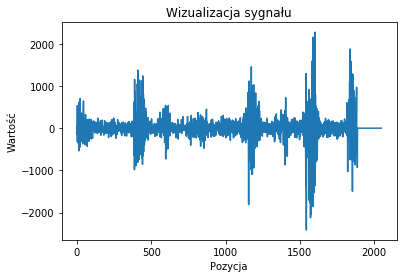

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(X_train[0])
plt.title('Wizualizacja sygnału')
plt.xlabel('Pozycja')
plt.ylabel('Wartość')

In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_train = X_train.reshape(2100,2048,1)
y_train = np.array(y_train).reshape(-1,1)

/home/wojciech/.conda/envs/data/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


<a id='_3'></a>
## 3. Wybór parametrów

In [7]:
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import MaxPool1D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras import backend as K
import tensorflow as tf

In [8]:
def create_model(optimizer='Adam',dropout_rate=0,conv_layers_and_dense_units=(2,128)):
    K.clear_session()
    sess = tf.Session()
    K.set_session(sess)
    cls = Sequential()
    cls.add(Conv1D(32,(3),input_shape=(2048,1)))
    cls.add(MaxPool1D(pool_size=(2,)))
    cls.add(Dropout(dropout_rate))
    for i in range(conv_layers_and_dense_units[0]):
        cls.add(Conv1D(32,(3)))
        cls.add(MaxPool1D(pool_size=(2,)))
        cls.add(Dropout(dropout_rate))
    cls.add(Flatten())
    cls.add(Dense(units = conv_layers_and_dense_units[1], activation = 'relu'))
    cls.add(Dropout(dropout_rate))
    cls.add(Dense(units = 1, activation = 'sigmoid'))
    cls.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return cls
param_grid = {'dropout_rate':np.arange(0,0.8,0.1), 'conv_layers_and_dense_units':[(1,256),(2,128),(3,64)]}

Testowane parametry warstwy ukrytej:
* 1 warstwa 256 neuronów
* 2 warstwy 128 neuronów
* 3 warstwy 64 neurony

W celu przeciwdziałania zbytniemu dopasowaniu, dla każdego testowego zestawu parametrów, część losowo wybranych neuronów była wyłączona z procesu treningu. Liczba pominiętych neuronów (ang. [dropout rate](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)) stanowiła od 0% do 80%.

In [9]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report,confusion_matrix
from tqdm import tqdm
metrics = [accuracy_score,classification_report,confusion_matrix]
kf = KFold(n_splits=3,random_state=47,shuffle=True)
results = []
for params in tqdm(ParameterGrid(param_grid)):
    for train_index, test_index in kf.split(X_train):
        X_train_tmp, X_test = X_train[train_index], X_train[test_index]
        y_train_tmp, y_test = y_train[train_index], y_train[test_index]
        cls = create_model(conv_layers_and_dense_units=params['conv_layers_and_dense_units'],
                          dropout_rate=params['dropout_rate'])
        history = cls.fit(X_train_tmp,y_train_tmp,epochs=20,validation_split=0.2,verbose=0)
        y_pred = cls.predict(X_test)
        result = {'history':history,'params':params}
        result['roc_auc_score']=roc_auc_score(y_test,y_pred)
        y_pred_c = y_pred > .5
        for m in metrics:
            result[m.__name__]=m(y_test,y_pred_c)
        results.append(result)

 92%|█████████▏| 22/24 [1:27:23<07:56, 238.35s/it]/home/wojciech/.conda/envs/data/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 24/24 [1:34:29<00:00, 236.23s/it]


In [10]:
import pandas as pd
df = pd.DataFrame(results)
df

,accuracy_score,classification_report,confusion_matrix,history,params,roc_auc_score
0,0.932857,precision recall f1-score s...,"[[398, 15], [32, 255]]",<keras.callbacks.History object at 0x7fe7531f3...,"{'conv_layers_and_dense_units': (1, 256), 'dro...",0.969375
1,0.915714,precision recall f1-score s...,"[[380, 39], [20, 261]]",<keras.callbacks.History object at 0x7fe73068f...,"{'conv_layers_and_dense_units': (1, 256), 'dro...",0.975047
2,0.920000,precision recall f1-score s...,"[[393, 25], [31, 251]]",<keras.callbacks.History object at 0x7fe753b66...,"{'conv_layers_and_dense_units': (1, 256), 'dro...",0.970418
3,0.944286,precision recall f1-score s...,"[[392, 21], [18, 269]]",<keras.callbacks.History object at 0x7fe753595...,"{'conv_layers_and_dense_units': (1, 256), 'dro...",0.977010
4,0.924286,precision recall f1-score s...,"[[381, 38], [15, 266]]",<keras.callbacks.History object at 0x7fe6e9829...,"{'conv_layers_and_dense_units': (1, 256), 'dro...",0.976860
5,0.937143,precision recall f1-score s...,"[[401, 17], [27, 255]]",<keras.callbacks.History object at 0x7fe6e9829...,"{'conv_layers_and_dense_units': (1, 256), 'dro...",0.977570
6,0.951429,precision recall f1-score s...,"[[391, 22], [12, 275]]",<keras.callbacks.History object at 0x7fe6b80c1...,"{'conv_layers_and_dense_units': (1, 256), 'dro...",0.977107
7,0.925714,precision recall f1-score s...,"[[401, 18], [34, 247]]",<keras.callbacks.History object at 0x7fe6a808b...,"{'conv_layers_and_dense_units': (1, 256), 'dro...",0.978232
8,0.924286,precision recall f1-score s...,"[[390, 28], [25, 257]]",<keras.callbacks.History object at 0x7fe6a0321...,"{'conv_layers_and_dense_units': (1, 256), 'dro...",0.973697
9,0.938571,precision recall f1-score s...,"[[381, 32], [11, 276]]",<keras.callbacks.History object at 0x7fe69895a...,"{'conv_layers_and_dense_units': (1, 256), 'dro...",0.979609


In [11]:
df['params_str']=df.params.astype(str)

In [12]:
group = df.groupby('params_str').roc_auc_score.mean().sort_values(ascending=False)
group

params_str
{'conv_layers_and_dense_units': (1, 256), 'dropout_rate': 0.6000000000000001}     0.981767
{'conv_layers_and_dense_units': (2, 128), 'dropout_rate': 0.5}                    0.981213
{'conv_layers_and_dense_units': (1, 256), 'dropout_rate': 0.5}                    0.981202
{'conv_layers_and_dense_units': (2, 128), 'dropout_rate': 0.1}                    0.980806
{'conv_layers_and_dense_units': (1, 256), 'dropout_rate': 0.4}                    0.980648
{'conv_layers_and_dense_units': (3, 64), 'dropout_rate': 0.30000000000000004}     0.979871
{'conv_layers_and_dense_units': (2, 128), 'dropout_rate': 0.4}                    0.978953
{'conv_layers_and_dense_units': (1, 256), 'dropout_rate': 0.30000000000000004}    0.978009
{'conv_layers_and_dense_units': (2, 128), 'dropout_rate': 0.2}                    0.977264
{'conv_layers_and_dense_units': (3, 64), 'dropout_rate': 0.2}                     0.977262
{'conv_layers_and_dense_units': (1, 256), 'dropout_rate': 0.1}                 

In [13]:
group.index[0]

"{'conv_layers_and_dense_units': (1, 256), 'dropout_rate': 0.6000000000000001}"

In [14]:
histories = df[df.params_str==group.index[0]].history.values

In [16]:
X_test, y_test = get_data_from_dir(test_dir,1,1)
X_test = pad_sequences(X_test, maxlen=2048,padding='post',truncating='post')
X_test = sc.transform(X_test)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
y_test = np.array(y_test).reshape(-1,1)

In [17]:
best_params = df[df.params_str==group.index[0]].params.values[0]

In [18]:
cls = create_model(conv_layers_and_dense_units=best_params['conv_layers_and_dense_units'],
                          dropout_rate=best_params['dropout_rate'])
history = cls.fit(X_train_tmp,y_train_tmp,epochs=20,verbose=1)

Epoch 1/20
1400/1400 [==============================] - 6s 4ms/step - loss: 0.8180 - acc: 0.5407
Epoch 2/20
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6735 - acc: 0.5986
Epoch 3/20
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6709 - acc: 0.5921
Epoch 4/20
1400/1400 [==============================] - 5s 3ms/step - loss: 0.6574 - acc: 0.6229
Epoch 5/20
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6192 - acc: 0.6600
Epoch 6/20
1400/1400 [==============================] - 6s 4ms/step - loss: 0.5829 - acc: 0.6993
Epoch 7/20
1400/1400 [==============================] - 5s 4ms/step - loss: 0.4727 - acc: 0.7836
Epoch 8/20
1400/1400 [==============================] - 5s 4ms/step - loss: 0.3991 - acc: 0.8314
Epoch 9/20
1400/1400 [==============================] - 5s 3ms/step - loss: 0.3153 - acc: 0.8729
Epoch 10/20
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2642 - acc: 0.8943
Epoch 11/20
1400/1400 [======

<a id='_4'></a>
## 4. Wyniki

In [19]:
y_pred = cls.predict(X_test)
accuracy_score(y_test,y_pred>.5)

0.7910447761194029

Uzyskano poprawność klasyfikacji na poziomie 79%.